# Random Forest and Lasso Model – Rolling Features (Max's Version)

This notebook builds a predictive model of MLB team win percentage (`WL%`) using Random Forest Regression and Lasso, with engineered rolling-average features.

Key steps:
- Clean and standardize team-level statistics (1984–2024)
- Generate 3-year rolling averages to smooth performance trends
- Train and evaluate Random Forest & Lasso models
- Predict `WL%` for 2025 using recent historical data (2022–2024)
- Visualize residuals vs. sportsbook projections

This notebook complements the SARIMAX and final Lasso models by offering a non-linear ensemble-based perspective and helping identify market inefficiencies.

In [20]:
##590 Project MLB Data 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

To model and predict team performance in Major League Baseball, we began by cleaning and standardizing the dataset, focusing on numeric features while excluding identifiers and outcome variables like wins, losses, and win percentage (WL%). The dataset was filtered to include seasons from 1984 to 2024, and features were normalized using StandardScaler. To capture historical trends, we engineered rolling-window features by averaging each team’s statistics from the three prior seasons. This allowed us to construct a training dataset where each observation represents a team’s 3-year historical average used to predict the subsequent season’s WL%. We trained a Random Forest Regressor on this data, using a standard 80/20 train-test split and evaluating performance via Root Mean Squared Error (RMSE). Once the model was trained, we applied it to forecast each team’s win percentage for the upcoming 2025 season. This was done by calculating the average of each team's statistics from 2022 to 2024, scaling them with the same parameters used during training, and generating predictions using the trained model. The result is a projected WL% for each team in 2025 based on their recent historical performance.

In [5]:

# Load the dataset
df_mlb = pd.read_csv('data/BaseballData590.csv', na_values=['?'])

# Select numeric feature columns (excluding 'Season' and 'WL%' since 'WL%' is the response)
numeric_cols = list(df_mlb.select_dtypes(include=["number"]).columns)
numeric_cols.remove('Season')
numeric_cols.remove('WL%')  # Do not normalize the response variable

# Initialize the scaler
scaler = StandardScaler()

# Normalize only the selected numeric feature columns
df_mlb[numeric_cols] = scaler.fit_transform(df_mlb[numeric_cols])

# Show a preview of the normalized DataFrame
print(df_mlb.head())


   Season Team  Lg         W       GP         L    WL%      Bat#        PA  \
0    2001  SEA  AL  2.603957  0.25746 -2.291710  0.716 -0.489353  0.653219   
1    1998  NYY  AL  2.464219  0.25746 -2.151677  0.704 -0.489353  0.609186   
2    2022  LAD  NL  2.254612  0.25746 -1.941626  0.685 -0.805760  0.320036   
3    2018  BOS  AL  2.045005  0.25746 -1.731576  0.667  0.354399  0.400763   
4    1986  NYM  NL  2.045005  0.25746 -1.731576  0.667 -0.067477  0.469748   

         AB  ...        WP        BF      ERA+       FIP      WHIP        H9  \
0  0.508010  ... -0.723946  0.098334  1.523646 -0.035582 -1.622735 -1.605185   
1  0.447001  ... -0.940048  0.104200  1.425072  0.028752 -1.090060 -0.803485   
2  0.254082  ... -0.868014 -0.240421  4.283716 -1.472353 -3.210316 -3.208586   
3  0.414023  ...  0.068427  0.200988  1.622220 -0.678912 -1.142283 -1.284505   
4  0.306846  ... -0.723946  0.199521  1.326498 -1.772573 -1.403398 -1.605185   

        HR9       BB9       SO9     SO/BB  
0  0.0

In [ ]:
df = df_mlb[df_mlb['Season'].between(1984, 2024)]

# Drop non-predictive columns
exclude_cols = ['W', 'L', 'WL%', 'GP']
meta_cols = ['Season', 'Team', 'Lg']
features = [col for col in df.columns if col not in exclude_cols + meta_cols]

In [7]:
# === 2. Sort and Build Rolling Features ===
df = df.sort_values(['Team', 'Season'])
df
# Create rolling window features (lagged stats)
feature_frames = []

for team, group in df.groupby('Team'):
    group = group.reset_index(drop=True)
    
    for i in range(3, len(group)):
        prev_stats = group.loc[i-3:i-1, features].mean()
        current_season = group.loc[i, 'Season']
        wl_pct = group.loc[i, 'WL%']

        row = {
            'Team': team,
            'Season': current_season,
            'WL%': wl_pct
        }
        row.update(prev_stats.to_dict())
        feature_frames.append(row)

model_df = pd.DataFrame(feature_frames)

# === 3. Train/Test Split ===
X = model_df.drop(columns=['Team', 'Season', 'WL%'])
y = model_df['WL%']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 4. Scale and Fit Model ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# === 5. Evaluate ===

preds = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, preds)
rmse = mse ** 0.5
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 0.0643


In [8]:
# === 6. Predict 2025 ===
future_rows = []

for team, group in df.groupby('Team'):
    group = group[group['Season'].between(2022, 2024)].reset_index(drop=True)
    
    if len(group) == 3:
        avg_stats = group[features].mean()
        row = {'Team': team, 'Season': 2025}
        row.update(avg_stats.to_dict())
        future_rows.append(row)

future_df = pd.DataFrame(future_rows)

X_2025 = future_df.drop(columns=['Team', 'Season'])
X_2025_scaled = scaler.transform(X_2025)
future_df['Predicted_WL%'] = model.predict(X_2025_scaled)

# Preview
print(future_df[['Team', 'Season', 'Predicted_WL%']])

   Team  Season  Predicted_WL%
0   ARI    2025        0.52227
1   ATL    2025        0.56034
2   BAL    2025        0.55018
3   BOS    2025        0.50691
4   CHC    2025        0.52474
5   CHW    2025        0.45911
6   CIN    2025        0.47346
7   CLE    2025        0.52573
8   COL    2025        0.44531
9   DET    2025        0.48567
10  HOU    2025        0.54695
11  KCR    2025        0.47850
12  LAA    2025        0.47449
13  LAD    2025        0.56770
14  MIA    2025        0.44608
15  MIL    2025        0.52804
16  MIN    2025        0.51208
17  NYM    2025        0.53292
18  NYY    2025        0.55078
19  OAK    2025        0.46939
20  PHI    2025        0.55523
21  PIT    2025        0.47277
22  SDP    2025        0.54815
23  SEA    2025        0.53146
24  SFG    2025        0.49526
25  STL    2025        0.51644
26  TBR    2025        0.54142
27  TEX    2025        0.50918
28  TOR    2025        0.48631
29  WSN    2025        0.45725


In [10]:
# Multiply predicted win percentage by 162 to get projected wins
future_df['Projected_Wins'] = future_df['Predicted_WL%'] * 162

# Sort teams by projected wins in descending order
future_df_sorted = future_df.sort_values(by='Projected_Wins', ascending=False).reset_index(drop=True)

# Preview the sorted results
print(future_df_sorted[['Team', 'Season', 'Predicted_WL%', 'Projected_Wins']])


   Team  Season  Predicted_WL%  Projected_Wins
0   LAD    2025        0.56770        91.96740
1   ATL    2025        0.56034        90.77508
2   PHI    2025        0.55523        89.94726
3   NYY    2025        0.55078        89.22636
4   BAL    2025        0.55018        89.12916
5   SDP    2025        0.54815        88.80030
6   HOU    2025        0.54695        88.60590
7   TBR    2025        0.54142        87.71004
8   NYM    2025        0.53292        86.33304
9   SEA    2025        0.53146        86.09652
10  MIL    2025        0.52804        85.54248
11  CLE    2025        0.52573        85.16826
12  CHC    2025        0.52474        85.00788
13  ARI    2025        0.52227        84.60774
14  STL    2025        0.51644        83.66328
15  MIN    2025        0.51208        82.95696
16  TEX    2025        0.50918        82.48716
17  BOS    2025        0.50691        82.11942
18  SFG    2025        0.49526        80.23212
19  TOR    2025        0.48631        78.78222
20  DET    20

In [13]:
#Importing Win Projections from Sportsbooks 

# Sportsbook win total projections for 2025
sportsbook_data = [
    # AL East
    ['NYY', 90.5],
    ['BAL', 83.5],
    ['BOS', 85.5],
    ['TBR', 80.5],
    ['TOR', 80.5],
    
    # AL Central
    ['CLE', 80.5],
    ['KCR', 82.5],
    ['DET', 86.5],
    ['MIN', 78.5],
    ['CHW', 54.5],
    
    # AL West
    ['HOU', 84.5],
    ['SEA', 84.5],
    ['TEX', 86.5],
    ['OAK', 70.5],
    ['LAA', 75.5],
    
    # NL East
    ['PHI', 93.5],
    ['ATL', 89.5],
    ['NYM', 93.5],
    ['WSN', 69.5],
    ['MIA', 63.5],
    
    # NL Central
    ['MIL', 81.5],
    ['STL', 76.5],
    ['CHC', 88.5],
    ['CIN', 79.5],
    ['PIT', 68.5],
    
    # NL West
    ['LAD', 105.5],
    ['SDP', 91.5],
    ['ARI', 87.5],
    ['SFG', 85.5],
    ['COL', 53.5]
]




# Create DataFrame
sportsbook_df = pd.DataFrame(sportsbook_data, columns=['Team', 'Sportsbook_Wins'])

# Add WL% column
sportsbook_df['WL%'] = sportsbook_df['Sportsbook_Wins'] / 162




In [15]:
# Merge model projections with sportsbook projections on 'Team'
merged_df = pd.merge(
    future_df_sorted[['Team', 'Season', 'Predicted_WL%', 'Projected_Wins']],
    sportsbook_df[['Team', 'Sportsbook_Wins', 'WL%']],
    on='Team',
    how='inner'  # Only keep teams that appear in both datasets
)

# Calculate residuals
merged_df['Win_Residual'] = merged_df['Projected_Wins'] - merged_df['Sportsbook_Wins']
merged_df['WL%_Residual'] = merged_df['Predicted_WL%'] - merged_df['WL%']

# Sort by residual if desired (e.g., biggest model > sportsbook discrepancy)
merged_df = merged_df.sort_values(by='Win_Residual', ascending=False).reset_index(drop=True)

# Preview
print(merged_df[['Team', 'Season', 'Projected_Wins', 'Sportsbook_Wins', 'Win_Residual']])


   Team  Season  Projected_Wins  Sportsbook_Wins  Win_Residual
0   CHW    2025        74.37582             54.5      19.87582
1   COL    2025        72.14022             53.5      18.64022
2   MIA    2025        72.26496             63.5       8.76496
3   PIT    2025        76.58874             68.5       8.08874
4   TBR    2025        87.71004             80.5       7.21004
5   STL    2025        83.66328             76.5       7.16328
6   BAL    2025        89.12916             83.5       5.62916
7   OAK    2025        76.04118             70.5       5.54118
8   CLE    2025        85.16826             80.5       4.66826
9   WSN    2025        74.07450             69.5       4.57450
10  MIN    2025        82.95696             78.5       4.45696
11  HOU    2025        88.60590             84.5       4.10590
12  MIL    2025        85.54248             81.5       4.04248
13  SEA    2025        86.09652             84.5       1.59652
14  LAA    2025        76.86738             75.5       

In [16]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# === 1. Sort and Build Rolling Averages ===
df = df.sort_values(['Team', 'Season'])

rolling_feature_rows = []

for team, group in df.groupby('Team'):
    group = group.reset_index(drop=True)
    
    for i in range(3, len(group)):
        rolling_avg = group.loc[i-3:i-1, features].mean()
        season = group.loc[i, 'Season']
        actual_wl = group.loc[i, 'WL%']
        
        row = {
            'Team': team,
            'Season': season,
            'WL%': actual_wl
        }
        row.update(rolling_avg.to_dict())
        rolling_feature_rows.append(row)

rolling_df = pd.DataFrame(rolling_feature_rows)

# === 2. Prepare Training Data ===
X_all = rolling_df.drop(columns=['Team', 'Season', 'WL%'])
y_all = rolling_df['WL%']

# === 3. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# === 4. Scale Data ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Cross-Validated Lasso ===
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Evaluate performance
best_alpha = lasso_cv.alpha_
lasso_preds = lasso_cv.predict(X_test_scaled)
lasso_rmse = mean_squared_error(y_test, lasso_preds) ** 0.5

print(f"Best alpha from cross-validation: {best_alpha:.4f}")
print(f"LassoCV Test RMSE: {lasso_rmse:.4f}")

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000590555920551239, tolerance: 0.0003501304776811595
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003935642353214419, tolerance: 0.0003501304776811595
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001644626704023544, tolerance: 0.0003501304776811595
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib

Best alpha from cross-validation: 0.0014
LassoCV Test RMSE: 0.0636


c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006193480871794499, tolerance: 0.0003689950683068018
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000857390790949264, tolerance: 0.0003689950683068018
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001054320245885254, tolerance: 0.0003689950683068018
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib

In [ ]:
# Get feature names
feature_names = X_all.columns

# Get Lasso coefficients
lasso_coefs = pd.Series(lasso_cv.coef_, index=feature_names)

# Show non-zero coefficients (variables Lasso kept)
print("🔹 Variables Lasso kept:")
print(lasso_coefs[lasso_coefs != 0].sort_values(ascending=False))

# Show zero coefficients (variables Lasso dropped)
print("Variables Lasso dropped:")
print(lasso_coefs[lasso_coefs == 0].index.tolist())


🔹 Variables Lasso kept:
OPS     0.010832
OPS+    0.007158
SLG     0.005318
BB      0.003217
HR      0.002220
SB      0.001955
SO      0.001575
HBPA   -0.000665
3B     -0.001134
HRA    -0.003201
GIDP   -0.003462
H9     -0.005448
HR9    -0.008502
WHIP   -0.011331
dtype: float64

❌ Variables Lasso dropped:
['Bat#', 'PA', 'AB', 'R', 'H', '1B', '2B', 'RBI', 'CS', 'BA', 'OBP', 'TB', 'HBP', 'SH', 'SF', 'IBB', 'LOB', 'R/Gm', 'WL%.1', 'ERA', 'CG', 'SHO', 'SV', 'IP', 'HA', 'RA', 'ER', 'BBA', 'IBBA', 'SOA', 'BK', 'WP', 'BF', 'ERA+', 'FIP', 'BB9', 'SO9', 'SO/BB']


To complement the Random Forest model, we also trained a regularized linear model using Lasso regression with cross-validation. Using the same rolling feature setup, we constructed a dataset where each team's win percentage (WL%) in a given season is predicted using the average of their statistics from the prior three years. After standardizing the features, we applied LassoCV with five-fold cross-validation to automatically select the optimal penalty term, alpha, which balances model simplicity and prediction accuracy. This approach enables both predictive modeling and variable selection by shrinking less important coefficients to zero. The model’s performance was evaluated using RMSE on the held-out test set, providing a benchmark for how well a linear model with regularization can capture trends in team performance over time.

In [17]:
# === 6. Predict for 2025 ===
future_rows = []

for team, group in df.groupby('Team'):
    group = group[group['Season'].between(2022, 2024)].reset_index(drop=True)
    
    if len(group) == 3:
        avg_stats = group[features].mean()
        row = {'Team': team, 'Season': 2025}
        row.update(avg_stats.to_dict())
        future_rows.append(row)

future_df = pd.DataFrame(future_rows)

# Prepare features for prediction
X_2025 = future_df.drop(columns=['Team', 'Season'])
X_2025_scaled = scaler.transform(X_2025)

# Predict 2025 win percentages
future_df['Predicted_WL%'] = lasso_cv.predict(X_2025_scaled)

# Multiply by 162 to get projected win totals
future_df['Projected_Wins'] = future_df['Predicted_WL%'] * 162

# Sort results
future_df_sorted = future_df.sort_values(by='Projected_Wins', ascending=False).reset_index(drop=True)

# Preview
print(future_df_sorted[['Team', 'Season', 'Predicted_WL%', 'Projected_Wins']])

   Team  Season  Predicted_WL%  Projected_Wins
0   LAD    2025       0.597515       96.797397
1   ATL    2025       0.576161       93.338027
2   HOU    2025       0.555648       90.015020
3   NYY    2025       0.552618       89.524186
4   PHI    2025       0.548825       88.909722
5   SEA    2025       0.544388       88.190903
6   BAL    2025       0.534445       86.580108
7   TBR    2025       0.533457       86.419963
8   SDP    2025       0.533185       86.375977
9   NYM    2025       0.532003       86.184443
10  MIN    2025       0.526121       85.231682
11  MIL    2025       0.526065       85.222562
12  TOR    2025       0.520551       84.329279
13  TEX    2025       0.518306       83.965615
14  STL    2025       0.516481       83.669986
15  CHC    2025       0.513387       83.168644
16  ARI    2025       0.509743       82.578336
17  SFG    2025       0.508148       82.319947
18  CLE    2025       0.508000       82.296061
19  BOS    2025       0.506117       81.991020
20  LAA    20

To generate win percentage forecasts for the 2025 MLB season, we used the Lasso regression model trained on rolling historical averages. For each team, we averaged their statistics from the 2022–2024 seasons to create a predictive profile for 2025. These features were scaled using the same transformation as in model training to ensure consistency. We then applied the trained Lasso model to generate predicted win percentages (WL%) for each team. These predictions were converted into projected win totals by multiplying the estimated WL% by 162 games. The final output ranks teams by projected wins, offering a data-driven outlook on team performance in the upcoming season.

In [ ]:
# === Merge Model Predictions with Sportsbook Projections ===
# Ensure both DataFrames have the same column name for joining
# 'Team' column already exists in both

merged_2025 = pd.merge(
    future_df_sorted[['Team', 'Season', 'Predicted_WL%', 'Projected_Wins']],
    sportsbook_df[['Team', 'Sportsbook_Wins', 'WL%']],
    on='Team',
    how='inner'  # Only keep teams that appear in both datasets
)

# === Calculate Residuals ===
merged_2025['Win_Residual'] = merged_2025['Projected_Wins'] - merged_2025['Sportsbook_Wins']
merged_2025['WL%_Residual'] = merged_2025['Predicted_WL%'] - merged_2025['WL%']

# === Sort by most positive difference (model > sportsbook) ===
merged_2025_sorted = merged_2025.sort_values(by='Win_Residual', ascending=False).reset_index(drop=True)

# === Preview ===
print(merged_2025_sorted[['Team', 'Season', 'Projected_Wins', 'Sportsbook_Wins', 'Win_Residual']])


   Team  Season  Projected_Wins  Sportsbook_Wins  Win_Residual
0   CHW    2025       71.478482             54.5     16.978482
1   COL    2025       68.795353             53.5     15.295353
2   MIA    2025       74.919051             63.5     11.419051
3   PIT    2025       76.152274             68.5      7.652274
4   STL    2025       83.669986             76.5      7.169986
5   MIN    2025       85.231682             78.5      6.731682
6   TBR    2025       86.419963             80.5      5.919963
7   HOU    2025       90.015020             84.5      5.515020
8   ATL    2025       93.338027             89.5      3.838027
9   TOR    2025       84.329279             80.5      3.829279
10  MIL    2025       85.222562             81.5      3.722562
11  SEA    2025       88.190903             84.5      3.690903
12  BAL    2025       86.580108             83.5      3.080108
13  LAA    2025       78.501580             75.5      3.001580
14  WSN    2025       71.793589             69.5      2

To assess how our model's 2025 projections align with market expectations, we merged our predicted win totals with external sportsbook data. This allowed us to compute residuals—differences between our model's forecasts and the sportsbook projections—for both win percentage (WL%) and total wins. Positive residuals indicate that our model expects better performance than the market does, while negative residuals suggest the opposite. By sorting teams by the largest positive win residuals, we identified which teams our model considers most undervalued relative to sportsbook expectations, offering insight into potential inefficiencies or unique signals captured by our data-driven approach.

C:\Users\mateo\AppData\Local\Temp\ipykernel_55016\1330390407.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


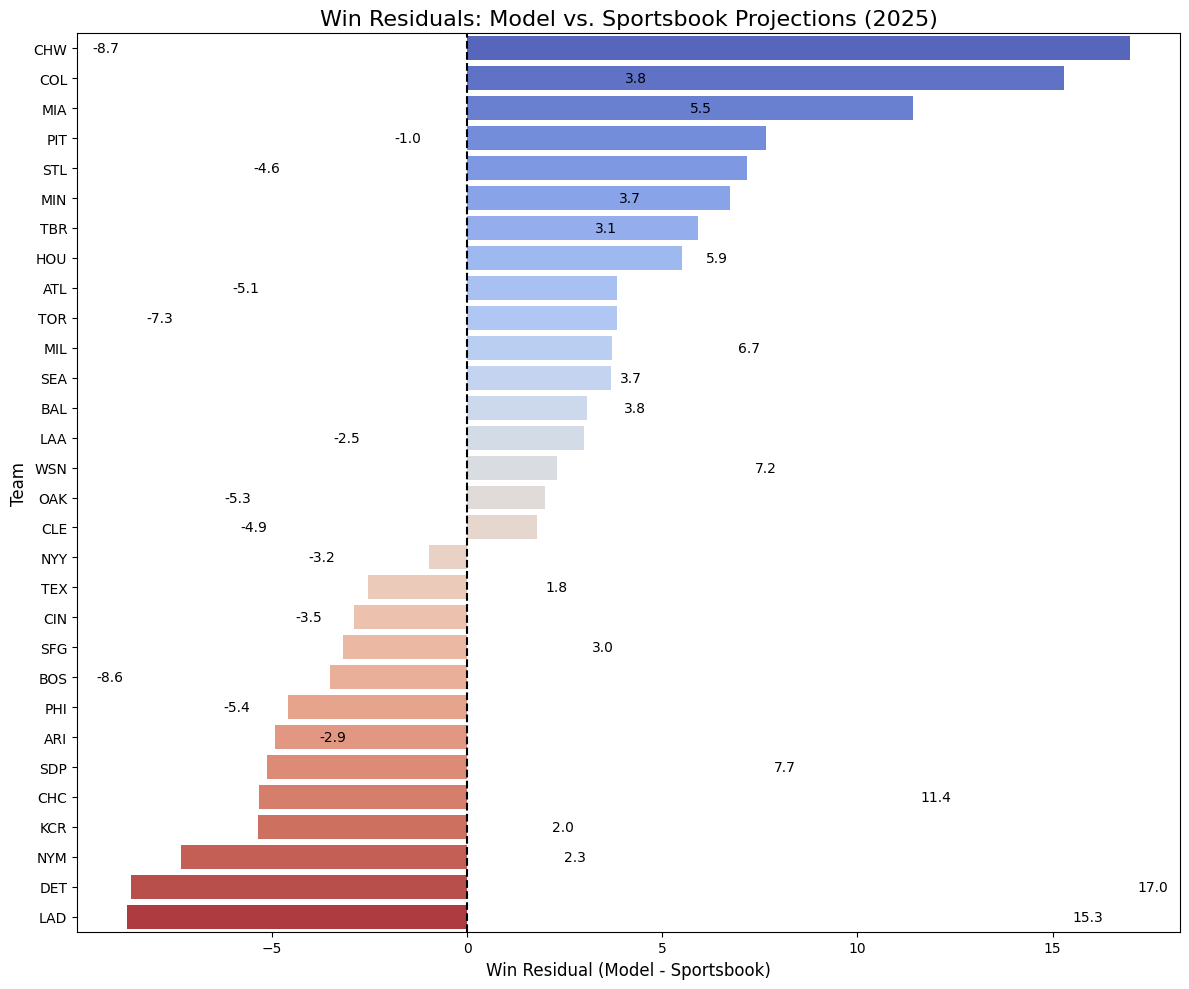

In [24]:
# Set figure size
plt.figure(figsize=(12, 10))

# Sort again just in case
merged_2025_sorted = merged_2025.sort_values(by='Win_Residual', ascending=False)

# Plot the barplot
barplot = sns.barplot(
    data=merged_2025_sorted,
    y='Team',
    x='Win_Residual',
    palette='coolwarm'
)

# Add a vertical line at 0 for reference
plt.axvline(0, color='black', linestyle='--')

# Add annotations (quantities)
for i, row in merged_2025_sorted.iterrows():
    x_offset = 0.2 if row['Win_Residual'] >= 0 else -0.2
    align = 'left' if row['Win_Residual'] >= 0 else 'right'
    
    barplot.text(
        row['Win_Residual'] + x_offset,
        i,
        f"{row['Win_Residual']:.1f}",
        color='black',
        ha=align,
        va='center',
        fontsize=10
    )

# Titles and labels
plt.title('Win Residuals: Model vs. Sportsbook Projections (2025)', fontsize=16)
plt.xlabel('Win Residual (Model - Sportsbook)', fontsize=12)
plt.ylabel('Team', fontsize=12)

# Improve spacing
plt.tight_layout()
plt.show()